In [1]:
# Importing relevant libraries and defining the Net class (same class with which the networks were generated)
import torch
import torch.nn as nn 
import torch.nn.functional as F

k=1
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Sequential(nn.Conv2d(3, 16*k,  kernel_size=3) , nn.BatchNorm2d(16*k),
                      nn.ReLU(inplace=True)), nn.Sequential(nn.Conv2d(16*k, 16*k,  kernel_size=3) , nn.BatchNorm2d(16*k),
                      nn.ReLU(inplace=True))] 
        self.layers+=[nn.Sequential(nn.Conv2d(16*k, 32*k,  kernel_size=3, stride=2),  nn.BatchNorm2d(32*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(32*k, 32*k,  kernel_size=3),  nn.BatchNorm2d(32*k),
              nn.ReLU(inplace=True)),nn.Sequential(nn.Conv2d(32*k, 32*k,  kernel_size=3),  nn.BatchNorm2d(32*k),
              nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(32*k, 64*k,  kernel_size=3, stride=2), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(64*k, 64*k,  kernel_size=3, padding='valid'), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(64*k, 64*k,  kernel_size=1), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+= [nn.AdaptiveAvgPool2d((1,1))]
        self.fc = nn.Linear(64*k, 10)
    
    def forward(self, x, acts_only=False,all_act=False):
        all_acts = []
        for i in range(len(self.layers)):
          all_acts.append(x)
          x = self.layers[i](x)

        x = self.fc(x.view(-1, 64*k))

        if all_act:
          return all_acts, x
        return x

This is the part to change

In [2]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# base_path = '/content/drive/MyDrive/CKA_proj/'

In [3]:
# Importing the saved networks
PATH='net_kornblith/net_kornblith_'

net_rand1 = Net()
net_rand1.load_state_dict(torch.load(PATH+'random_1.zip'))
net_rand1.eval()

net_rand2 = Net()
net_rand1.load_state_dict(torch.load(PATH+'random_2.zip'))
net_rand2.eval()

net_all1 = Net()
net_all1.load_state_dict(torch.load(PATH+'all_1.zip'))
net_all1.eval()

net_all2 = Net()
net_all2.load_state_dict(torch.load(PATH+'all_2.zip'))
net_all2.eval()

net_mem_s1 = Net()
net_mem_s1.load_state_dict(torch.load(PATH+'mem_1_set1.zip'))
net_mem_s1.eval()

net_mem_s2 = Net()
net_mem_s2.load_state_dict(torch.load(PATH+'mem_2_set2.zip'))
net_mem_s2.eval()

Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

In [4]:
# Defining linear CKA

import torch.nn as nn
import torch.nn.functional as F

class LinCKA(nn.Module):
    def __init__(self, n=1000):
        super(LinCKA, self).__init__()
        self.resetK(n)
    
    def resetK(self,n):
        unit = torch.ones([n, n])
        I = torch.eye(n)
        H = I - unit / n
        H = H.cuda()
        self.H = H.cuda()
        self.n = n

    def centering(self, K):
        H = self.H
        return torch.matmul(torch.matmul(H, K), H) 

    def linear_HSIC(self, X, Y):
        L_X = torch.matmul(X, X.T)
        L_Y = torch.matmul(Y, Y.T)
        return torch.sum(self.centering(L_X) * self.centering(L_Y))

    def linear_CKA(self,X, Y):
        hsic = self.linear_HSIC(X, Y)
        var1 = torch.sqrt(self.linear_HSIC(X, X))
        var2 = torch.sqrt(self.linear_HSIC(Y, Y))

        return hsic / (var1 * var2),var1,var2

    def forward(self, X,Y):
        if len(X) != self.n:
          self.resetK(len(X))
        return self.linear_CKA(X,Y)

CKA = LinCKA()

In [5]:
from numpy.random import RandomState
import numpy as np
import torch
  
from torchvision import datasets, transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) 
transform_train =  transforms.Compose([transforms.ToTensor(), normalize]) 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
cifar_data_test = datasets.CIFAR10(root='.',train=False, transform=transform_val, download=True)
n=10000
val_loaderx = torch.utils.data.DataLoader(cifar_data_test,
                                           batch_size=n, 
                                           shuffle=True)
data, labels = iter(val_loaderx).next()
data = data.to(device)

train_loaderx = torch.utils.data.DataLoader(cifar_data,
                                           batch_size=50000, 
                                           shuffle=True)
train_data, train_labels = iter(train_loaderx).next()
train_data = train_data.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
def NetCompare(modelA,modelB):
  np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
  modelA.cuda()
  modelB.cuda()
  all_acts1,_ = modelA.forward(data, all_act=True)
  all_acts2,_ = modelB.forward(data, all_act=True)
  torch.cuda.empty_cache()
  ckas = []
  for (acts1,acts2) in zip(all_acts1,all_acts2):
      b1=b2=acts1.shape[0]
      acts1 = acts1.data.cuda()
      acts2 = acts2.data.cuda()

      cka, var1, var2 = CKA(acts1.view(b1,-1).squeeze(),
                    acts2.view(b2,-1).squeeze())
      ckas.append(cka.item())
  print(np.array(ckas))
  return ckas

In [ ]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

print('Generalize (init1) v Generalize (init2)')
NetCompare(net_all1, net_all2)
print('Rand v Rand')
NetCompare(net_rand1,net_rand2)
print('Rand v Gen')
NetCompare(net_rand1, net_all1)
print('Mem(init1, data1) v Mem(init2, data2)')
NetCompare(net_mem_s1, net_mem_s2)
print('Mem v gen')
NetCompare(net_mem_s1, net_all1)
print('Mem v rand')
NetCompare(net_mem_s1, net_rand1)

# Class stretching experiments

## Toy experiments

In [6]:
num_points = 200
data = np.random.default_rng().uniform(size=(num_points, 2))
labels = np.ones(num_points)
labels[np.where(data[:,0]<0.5)] = -1

In [7]:
from sklearn.svm import LinearSVC
lin_class = LinearSVC()
lin_class.fit(data,labels)
W = lin_class.coef_[0]
I = lin_class.intercept_
a = -W[0]/W[1]
b = I[0]/W[1]

print(lin_class.coef_.shape)
print(I)

(1, 2)
[-2.28180073]


In [8]:
import matplotlib.pyplot as plt
plt.scatter(data[:,0], data[:,1], c=labels)
x = np.linspace(0,1,10)
y = a*x-b
plt.plot(x,y)
plt.plot([0,W[0]],[0,W[1]])
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([-0.5, 1])

(-0.5, 1)

This seems to work...

## Real data

In [6]:
from sklearn.svm import LinearSVC

net_all1.cuda()
# val_activations, _ = net_all1.forward(data, all_act=True)
train_activations, _ = net_all1.forward(train_data, all_act=True)
print(len(train_activations))
print([i.shape for i in train_activations])
print([i.view(i.shape[0],-1).shape for i in train_activations])

train_act = train_activations[-1].view(train_activations[-1].shape[0],-1).detach().cpu().numpy()
train_labels = train_labels.detach().cpu().numpy()
for i in train_activations: del i

9
[torch.Size([50000, 3, 32, 32]), torch.Size([50000, 16, 30, 30]), torch.Size([50000, 16, 28, 28]), torch.Size([50000, 32, 13, 13]), torch.Size([50000, 32, 11, 11]), torch.Size([50000, 32, 9, 9]), torch.Size([50000, 64, 4, 4]), torch.Size([50000, 64, 2, 2]), torch.Size([50000, 64, 2, 2])]
[torch.Size([50000, 3072]), torch.Size([50000, 14400]), torch.Size([50000, 12544]), torch.Size([50000, 5408]), torch.Size([50000, 3872]), torch.Size([50000, 2592]), torch.Size([50000, 1024]), torch.Size([50000, 256]), torch.Size([50000, 256])]


In [7]:
lin_svc = LinearSVC()
lin_svc.fit(train_act, train_labels)

# Gives data proportional to signed distances from decision boundary for each class
decision_function = lin_svc.decision_function(train_act)
print(decision_function[0])

# Trouver les decision boundaries
print(lin_svc.coef_.shape) # Donne les 10 vecteurs normaux au décision boundary
print(lin_svc.intercept_.shape[0]) # Donne le offset par rapport à l'origine

[ 1.30012367 -2.99292764 -2.98123247 -4.62078575 -3.85792429 -3.74176933
 -3.24900056 -2.08518153 -4.36379135 -3.32110704]
(10, 256)
10


/cvmfs/ai.mila.quebec/apps/x86_64/debian/anaconda/3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [8]:
# Linear separability:
print("Accuracy of a linear SVM classifier: {}".format(lin_svc.score(train_act, train_labels)))

Accuracy of a linear SVM classifier: 0.9116


In [9]:
def get_activations_by_class(data, labels):
    indexes = []
    datapoints = []
    
    for label in range(10): #for label in set(labels): 
        indexes.append(np.where(labels==label))
        datapoints.append(data[indexes[-1]])
    
    return datapoints, indexes

## PCA

87


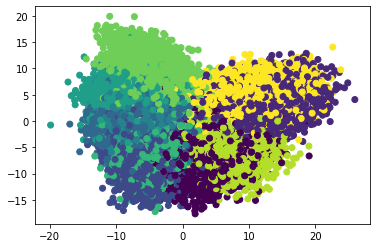

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
lowd_embeds = pca.fit_transform(train_act)
pca.explained_variance_ratio_
plt.scatter(lowd_embeds[:,0], lowd_embeds[:,1], c=train_labels)

pca_var = PCA(n_components = 0.9)
pca_var.fit(train_act)
print(len(pca_var.components_))

In [16]:
pts_per_class, indexes = get_activations_by_class(train_act, train_labels)
explained_var = 0.8

pcs_per_class = []

for class_idx, pts_class in enumerate(pts_per_class):
    pca = PCA(n_components = explained_var)
    pcs_per_class.append(pca.fit(pts_class).components_)
    print("Class {} requires {} PCs for {}% explained class variance".format(class_idx, len(pcs_per_class[-1]), explained_var*100))
    lowd_lin_svc = LinearSVC()
    

Class 0 requires 41 PCs for 80.0% explained class variance
Class 1 requires 41 PCs for 80.0% explained class variance
Class 2 requires 46 PCs for 80.0% explained class variance
Class 3 requires 52 PCs for 80.0% explained class variance
Class 4 requires 43 PCs for 80.0% explained class variance
Class 5 requires 49 PCs for 80.0% explained class variance
Class 6 requires 46 PCs for 80.0% explained class variance
Class 7 requires 42 PCs for 80.0% explained class variance
Class 8 requires 44 PCs for 80.0% explained class variance
Class 9 requires 46 PCs for 80.0% explained class variance


## Stretch all dirs

In [35]:
def stretch_all_dirs_except_one(data, w, stretch_constant):
    # data should be of shape n x d (n examples, d features)
    # w should be a d dimensional vector
    data_ = np.copy(data)
    w = w.reshape([1,len(w)])
    
#     print(w.shape)
#     print(data_.shape)
#     print(np.ones([data_.shape[0],1]).shape)
#     print(np.matmul(data_, w.T).shape)
#     print(np.diag(np.matmul(data_, w.T)).shape)
    residue = np.matmul( np.diag(np.matmul(data_, w.T).squeeze()), np.matmul(np.ones([data_.shape[0],1]), w)) #.squeeze() équivalent à .reshape(-1)
    data_ = data_ - residue
    data_ *= stretch_constant
    data_ += residue
    return data_

In [39]:
pts_per_class, indexes = get_activations_by_class(train_act, train_labels)
stretched_pts = []
new_labels = np.zeros(len(pts_per_class[0]))

stretch_constant = 1000000

for class_idx, (data, w) in enumerate(zip(pts_per_class, lin_svc.coef_)):
    stretched_pts.append(stretch_all_dirs_except_one(data,w, stretch_constant))
    if class_idx != 0: new_labels = np.concatenate([new_labels, class_idx*np.ones(stretched_pts[-1].shape[0])])    

In [40]:
# Linear separability:
stretched_pts = np.concatenate(stretched_pts)
pts_per_class = np.concatenate(pts_per_class)

print("Accuracy of a linear SVM classifier: {}".format(lin_svc.score(stretched_pts, new_labels)))

Accuracy of a linear SVM classifier: 0.94574


In [41]:
CKA = LinCKA()

perm = np.random.permutation(1000)
original = torch.Tensor(pts_per_class).cuda()
stretched = torch.Tensor(stretched_pts).cuda()
print("Cka between 1000 stretched pts: {}".format(CKA(stretched[perm], stretched[perm])[0].item()))
print("Cka between 1000 original pts: {}".format(CKA(original[perm], original[perm] )[0].item()))
print("Cka between 1000 original vs stretched pts: {}".format(CKA(original[perm],stretched[perm] )[0].item()))

Cka between 1000 stretched pts: 1.0000001192092896
Cka between 1000 original pts: 1.0
Cka between 1000 original vs stretched pts: 0.9997718930244446


Maintains the accuracy of the SVM classifier but also maintains CKA

## Splitting

In [10]:
def split_one_dir_except_one(data, d, w, split_constant):
    # data should be of shape n x d (n examples, d features)
    # w should be a d dimensional vector
    data_ = np.copy(data)
    w = w.reshape([1,len(w)])
    d = d.reshape([1,np.max(d.shape)])
    d_ = d - np.matmul(w,d.T)*w
    
    projections = np.matmul(data_, d_.T).squeeze()
    mean = np.mean(projections)
    translations = np.ones(data_.shape[0])
    translations[np.where(projections<mean)] = -1
    translations = np.matmul( np.diag(translations.squeeze()), np.matmul(np.ones([data_.shape[0],1]), d_))
    
    data_+=translations
    return data_

In [11]:
def multiple_splits_one_dir_except_one(data, d, w, split_constant, n_clusters):
    # data should be of shape n x d (n examples, d features)
    # w should be a d dimensional vector
    data_ = np.copy(data)
    w = w.reshape([1,len(w)])
    d = d.reshape([1,np.max(d.shape)])
    d_ = d - np.matmul(w,d.T)*w
    
    projections = np.matmul(data_, d_.T).squeeze()
    mean = np.mean(projections)
    min_ = np.min(projections)
    max_ = np.max(projections)
# new_points = np.copy(points)
#     separators = np.linspace(0,1,num_clusters+1)-0.5
#     for point in new_points:
#         for cluster_idx in range(num_clusters):
#             if point[1]>= separators[cluster_idx] and point[1]< separators[cluster_idx+1]:
#                 point[1]+= cluster_idx*cluster_dist
#     return new_points
    
    translations = np.zeros(data_.shape[0])
    
    separators = np.linspace(min_,max_,n_clusters)
    for cluster_idx in range(n_clusters):
        translations[np.where(projections>=separators[cluster_idx])] = cluster_idx*split_constant 
    
    translations = np.matmul( np.diag(translations.squeeze()), np.matmul(np.ones([data_.shape[0],1]), d_))
    
    data_+= translations
    return data_

In [12]:
def multiple_splits_one_dir_except_multiple(data, d, W, split_constant, n_clusters):
    # data should be of shape n x d (n examples, d features)
    # w should be a d dimensional vector
    data_ = np.copy(data)
    d_ = d.reshape([1,np.max(d.shape)])
    for w in W:
        d_ -= np.matmul(w,d_.T)*w
    
    projections = np.matmul(data_, d_.T).squeeze()
    mean = np.mean(projections)
    min_ = np.min(projections)
    max_ = np.max(projections)
    
    translations = np.zeros(data_.shape[0])
    
    separators = np.linspace(min_,max_,n_clusters)
    for cluster_idx in range(n_clusters):
        translations[np.where(projections>=separators[cluster_idx])] = cluster_idx*split_constant 
    
    translations = np.matmul(np.diag(translations.squeeze()), np.matmul(np.ones([data_.shape[0],1]), d_))
    
    data_+= translations
    return data_

In [10]:
def multiple_splits_one_dir(data, d, W, split_constant, n_clusters):
    # data should be of shape n x d (n examples, d features)
    # 
    data_ = np.copy(data)
    
    Q, R = np.linalg.qr(W.T)
    d_ = d.reshape([1,np.max(d.shape)])
    d_ -= np.matmul(d_, np.matmul(Q, Q.T))
    
    projections = np.matmul(data_, d_.T).squeeze()
    mean = np.mean(projections)
    min_ = np.min(projections)
    max_ = np.max(projections)
    
    translations = np.zeros(data_.shape[0])
    
    separators = np.linspace(min_,max_,n_clusters)
    for cluster_idx in range(n_clusters):
        translations[np.where(projections>=separators[cluster_idx])] = cluster_idx*split_constant 
    
    translations = np.matmul(np.diag(translations.squeeze()), np.matmul(np.ones([data_.shape[0],1]), d_))
    
    data_+= translations
    return data_

In [32]:
from sklearn.decomposition import PCA
pts_per_class, indexes = get_activations_by_class(train_act, train_labels)
stretched_pts = []
new_labels = np.zeros(len(pts_per_class[0]))

split_constant = 10000

for class_idx, data in enumerate(pts_per_class):
    d = PCA(n_components=50).fit(data).components_[4]
    stretched_pts.append(multiple_splits_one_dir(data, d, lin_svc.coef_, split_constant, 3))
    if class_idx != 0: new_labels = np.concatenate([new_labels, class_idx*np.ones(stretched_pts[-1].shape[0])])
        
# Linear separability:
stretched_pts = np.concatenate(stretched_pts)
pts_per_class = np.concatenate(pts_per_class)

print("Accuracy of a linear SVM classifier on the original data: {}".format(lin_svc.score(pts_per_class, new_labels)))
print("Accuracy of a linear SVM classifier on the split data: {}".format(lin_svc.score(stretched_pts, new_labels)))


# CKA values
CKA = LinCKA()

num_pts_cka = 10000
perm = np.random.permutation(num_pts_cka)
original = torch.Tensor(pts_per_class).cuda()
stretched = torch.Tensor(stretched_pts).cuda()
print("Cka between {} stretched pts: {}".format(num_pts_cka, CKA(stretched[perm], stretched[perm])[0].item()))
print("Cka between {} original pts: {}".format(num_pts_cka, CKA(original[perm], original[perm] )[0].item()))
print("Cka between {} original vs stretched pts: {}".format(num_pts_cka, CKA(original[perm],stretched[perm])[0].item()))

Accuracy of a linear SVM classifier on the original data: 0.91334
Accuracy of a linear SVM classifier on the split data: 0.91334
Cka between 10000 stretched pts: 1.0
Cka between 10000 original pts: 0.9999999403953552
Cka between 10000 original vs stretched pts: 0.3163566589355469


## All combined in a single cell

In [17]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

def get_activations_by_class(data, labels):
    indexes = []
    datapoints = []
    
    for label in range(10): #for label in set(labels): 
        indexes.append(np.where(labels==label))
        datapoints.append(data[indexes[-1]])
    
    return datapoints, indexes

def multiple_splits_one_dir(data, d, W, split_constant, n_clusters):
    # data should be of shape n x d (n examples, d features)
    # 
    data_ = np.copy(data)
    
    Q, R = np.linalg.qr(W.T)
    d_ = d.reshape([1,np.max(d.shape)])
    d_ -= np.matmul(d_, np.matmul(Q, Q.T))
    
    projections = np.matmul(data_, d_.T).squeeze()
    mean = np.mean(projections)
    min_ = np.min(projections)
    max_ = np.max(projections)
    
    translations = np.zeros(data_.shape[0])
    
    separators = np.linspace(min_,max_,n_clusters)
    for cluster_idx in range(n_clusters):
        translations[np.where(projections>=separators[cluster_idx])] = cluster_idx*split_constant 
    
    translations = np.matmul(np.diag(translations.squeeze()), np.matmul(np.ones([data_.shape[0],1]), d_))
    
    data_+= translations
    return data_


train_data, train_labels = iter(train_loaderx).next()
train_data = train_data.to(device)
net_all1.cuda()
train_activations, _ = net_all1.forward(train_data, all_act=True)
train_act = train_activations[-1].view(train_activations[-1].shape[0],-1).detach().cpu().numpy()
train_labels = train_labels.detach().cpu().numpy()
for i in train_activations: del i

# Linear separability:
lin_svc = LinearSVC()
lin_svc.fit(train_act, train_labels)
print("Accuracy of a linear SVM classifier on the original data: {}".format(lin_svc.score(train_act, train_labels)))


pts_per_class, indexes = get_activations_by_class(train_act, train_labels)
stretched_pts = []
new_labels = np.zeros(len(pts_per_class[0]))

split_constant = 1000

for class_idx, data in enumerate(pts_per_class):
    d = PCA(n_components=50).fit(data).components_[4]
    stretched_pts.append(multiple_splits_one_dir(data, d, lin_svc.coef_, split_constant, 2))
    if class_idx != 0: new_labels = np.concatenate([new_labels, class_idx*np.ones(stretched_pts[-1].shape[0])])
        
# Linear separability:
stretched_pts = np.concatenate(stretched_pts)
pts_per_class = np.concatenate(pts_per_class)

# print("Accuracy of a linear SVM classifier on the original data: {}".format(lin_svc.score(pts_per_class, new_labels)))
print("Accuracy of a linear SVM classifier on the split data: {}".format(lin_svc.score(stretched_pts, new_labels)))


# CKA values
CKA = LinCKA()

num_pts_cka = 10000
perm = np.random.permutation(num_pts_cka)
original = torch.Tensor(pts_per_class).cuda()
stretched = torch.Tensor(stretched_pts).cuda()
print("Cka between {} stretched pts: {}".format(num_pts_cka, CKA(stretched[perm], stretched[perm])[0].item()))
print("Cka between {} original pts: {}".format(num_pts_cka, CKA(original[perm], original[perm] )[0].item()))
print("Cka between {} original vs stretched pts: {}".format(num_pts_cka, CKA(original[perm],stretched[perm])[0].item()))

/cvmfs/ai.mila.quebec/apps/x86_64/debian/anaconda/3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of a linear SVM classifier on the original data: 0.91334
Accuracy of a linear SVM classifier on the split data: 0.91334
Cka between 10000 stretched pts: 1.0
Cka between 10000 original pts: 1.0
Cka between 10000 original vs stretched pts: 0.6025434732437134


# **Target exp**

In [ ]:
def Map(all_acts):
  n = len(all_acts)
  map = torch.zeros(n,n)
  for i in range(len(all_acts)):
    for j in range(len(all_acts)):
      b = all_acts[i].shape[0]
      acts1 = all_acts[i].view(b,-1).squeeze()
      acts2 = all_acts[j].view(b,-1).squeeze()
      cka, _, _ = CKA(acts1,acts2)
     # print(cka.item())
   
      map[i,j] = cka

  return map

In [ ]:
def MapTarg(all_acts,mapTarget):
  n = len(all_acts)
  mapLoss = 0
  for i in range(len(all_acts)):
    for j in range(len(all_acts)):
      if i == j: 
        continue
      b = all_acts[i].shape[0]
      acts1 = all_acts[i].view(b,-1).squeeze()
      acts2 = all_acts[j].view(b,-1).squeeze()
      cka, _, _ = CKA(acts1,acts2)
     # print(cka.item())
   
      mapLoss+= (cka-mapTarget[i,j])**2

  return mapLoss/float(n**2)

In [ ]:
#original
all_acts1,_ = net_mem1.forward(data,all_act=True)
import matplotlib.pyplot as plt
for i in range(len(all_acts1)):
  all_acts1[i] = all_acts1[i].cuda()
plt.imshow(Map(all_acts1[1:]).cpu().data.numpy(),origin='lower')
plt.colorbar()
plt.clim(0.3,1)

In [ ]:
import torch.nn.functional as F

def trainMap(model, device, train_loader, optimizer, epoch, mapTarget, lam=20.0,display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):      
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
      #  output = model(data)
        all_acts, output = model.forward(data, all_act=True)
        loss = F.cross_entropy(output, target)
        #map = Map(all_acts)
        #print(map)
        maploss = MapTarg(all_acts,mapTarget) #F.mse_loss(map,mapTarget)
        if batch_idx%10==0:
          print(maploss)
        
        loss += lam*maploss
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
all_acts1,_ = modelsA[0].forward(data,all_act=True)
mapTarget = Map(all_acts1).cpu().data.numpy()#torch.zeros(len(all_acts1),len(all_acts1))
mapTarget[1,8]=1
mapTarget[8,1]=1
plt.imshow(mapTarget[1:,1:],origin='lower')
plt.colorbar()
plt.clim(0.3,1)

In [ ]:
#mapTarget = torch.ones(len(all_acts1),len(all_acts1))

train_loader1 = torch.utils.data.DataLoader(train_data1,
                                             batch_size=1000, 
                                             shuffle=True)
model = copy.deepcopy(modelsA[0])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
for epoch in range(5):
  trainMap(model, device, train_loader1, optimizer, epoch, mapTarget)

test(model, device, val_loader2)

In [ ]:
all_acts1, _ = model(data,all_act=True)
for i in range(len(all_acts1)):
  all_acts1[i] = all_acts1[i].cuda()
plt.imshow(Map(all_acts1[1:]).cpu().data.numpy(),origin='lower')
plt.colorbar()
plt.clim(0.3,1)

In [ ]:
#all ones target
mapTarget = torch.ones(len(all_acts1),len(all_acts1))

train_loader1 = torch.utils.data.DataLoader(train_data1,
                                             batch_size=1000, 
                                             shuffle=True)
model = copy.deepcopy(modelsA[0])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
for epoch in range(2):
  trainMap(model, device, train_loader1, optimizer, epoch, mapTarget,lam=2.0)

test(model, device, val_loader2)

In [ ]:
all_acts1, _ = model(data,all_act=True)
for i in range(len(all_acts1)):
  all_acts1[i] = all_acts1[i].cuda()
plt.imshow(Map(all_acts1[1:]).cpu().data.numpy(),origin='lower')
plt.colorbar()
plt.clim(0.3,1)

In [ ]:
all_acts1,_ = modelsA[0].forward(data,all_act=True)
mapTarget = Map(all_acts1).cpu().data.numpy()#torch.zeros(len(all_acts1),len(all_acts1))
mapTarget[7,8]=0
mapTarget[8,7]=0
plt.imshow(mapTarget[1:,1:],origin='lower')
plt.colorbar()
plt.clim(0.3,1)

In [ ]:
train_loader1 = torch.utils.data.DataLoader(train_data1,
                                             batch_size=1000, 
                                             shuffle=True)
model = copy.deepcopy(modelsA[0])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
for epoch in range(5):
  trainMap(model, device, train_loader1, optimizer, epoch, mapTarget)

test(model, device, val_loader2)